## **Anomaly Detection**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
df_with_anomaly = pd.read_csv('art_daily_jumpsup.csv',parse_dates=True, index_col="timestamp")

In [9]:
df_with_no_anomaly = pd.read_csv('art_daily_small_noise.csv',parse_dates=True, index_col="timestamp")

In [10]:
df_with_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [11]:
df_with_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


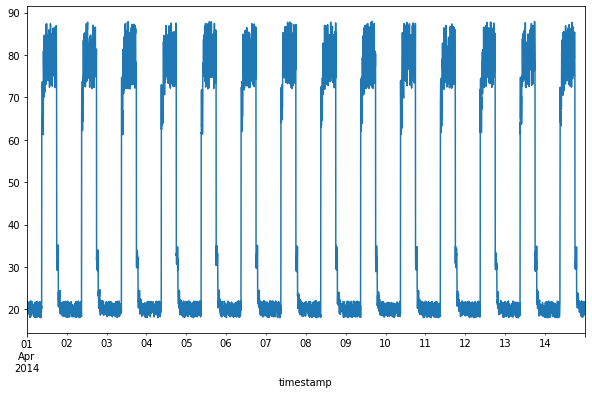

In [32]:
fig, ax = plt.subplots()
df_with_no_anomaly.plot(legend=False, figsize = (10,6),ax=ax)
plt.show()

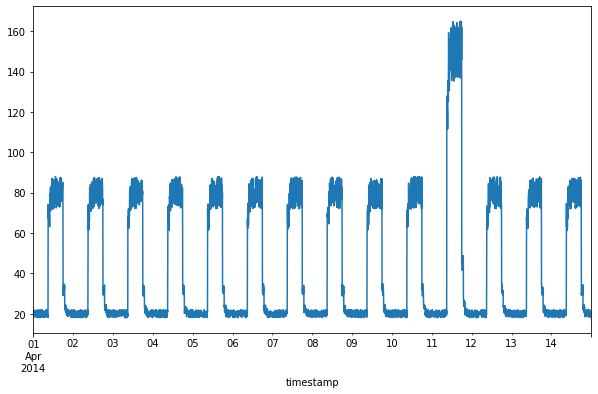

In [31]:
fig, ax = plt.subplots()
df_with_anomaly.plot(legend=False, figsize = (10,6),ax=ax)
plt.show()

### **Training Data Preparation**

In [14]:
#Normalizing the data
train_avg = df_with_no_anomaly.mean()
train_std = df_with_no_anomaly.std()
df_train = (df_with_no_anomaly - train_avg)/train_std

In [16]:
len(df_train)

4032

In [17]:
#There are 288 timesteps per day (24*60/5)
steps = 288
#Creating sequences of data
def sequences(data,steps = 288):
    output = []
    for i in  range(len(data) - steps):
        output.append(data[i:(i+steps)])
    return np.stack(output)

In [18]:
x_train = sequences(df_train.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


### **Model Building**

In [19]:
#Building Autoencoder model
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

**Note: Conv1d_transpose doesn't work with tensorflow 2.2.0 and started working fine after upgrading tf to 2.3.0**

In [25]:
#we are using x_train as both the input and the target since this is a reconstruction model.
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
53/53 [==============================] - 3s 59ms/step - loss: 0.0187 - val_loss: 0.0204
Epoch 2/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0174 - val_loss: 0.0209
Epoch 3/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0163 - val_loss: 0.0205
Epoch 4/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 5/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0142 - val_loss: 0.0181
Epoch 6/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0132 - val_loss: 0.0165
Epoch 7/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0123 - val_loss: 0.0161
Epoch 8/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0114 - val_loss: 0.0154
Epoch 9/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0106 - val_loss: 0.0149
Epoch 10/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0099 - val_loss: 0.0127
Epoch 11/

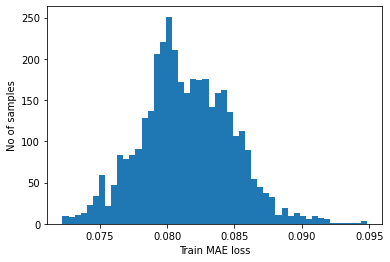

Reconstruction error threshold:  0.09481846159173685


In [27]:
#Making max MAE loss value as the threshold for Anomaly detection

# Get train MAE loss.
x_train_predict = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_predict - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

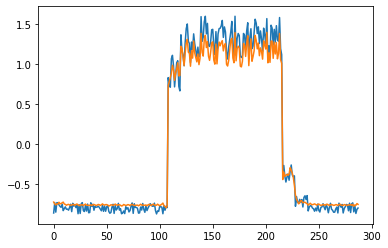

In [28]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_predict[0])
plt.show()

### **Test Data Preparation**

In [29]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

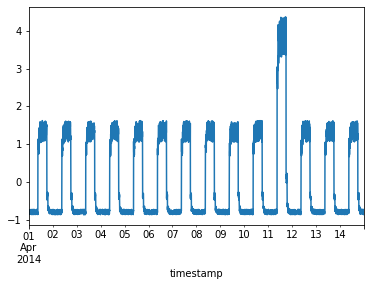

Test input shape:  (3744, 288, 1)


In [30]:
df_test_value = (df_with_anomaly - train_avg) / train_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

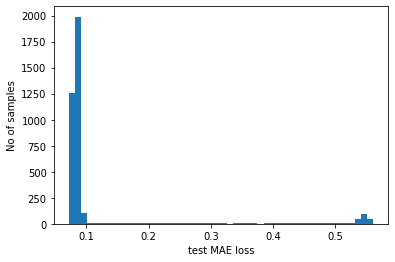

In [33]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [34]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  408
Indices of anomaly samples:  (array([ 680,  775,  790,  791,  793,  794,  795, 1942, 1945, 1946, 2120,
       2521, 2698, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2

In [36]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(steps - 1, len(df_test_value) - steps + 1):
    if np.all(anomalies[data_idx - steps + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

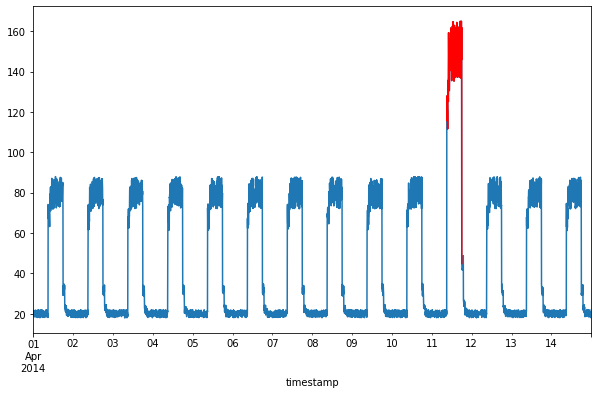

In [39]:
df_subset = df_with_anomaly.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_with_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r",figsize = (10,6))
plt.show()